# Sea Animals Pytorch Lightning CNN

https://www.kaggle.com/code/stpeteishii/embryo-quality-pytorch-lightning-cnn

In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

/home/william/MLOps/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vencerlanz09/sea-animals-image-dataste")

print("Path to dataset files:", path)

path

Path to dataset files: /home/william/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5


'/home/william/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5'

In [3]:
classes=[]
paths=[]
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('.png') or filename.endswith('.jpg') :
            classes+=[dirname.split('/')[-1]]
            paths+=[(os.path.join(dirname, filename))]
print(len(paths))

13711


In [4]:
N=list(range(len(classes)))
class_names=sorted(set(classes))
print(class_names)
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))       

data=pd.DataFrame(columns=['path','class','label'])
data['path']=paths
data['class']=classes
data['label']=data['class'].map(normal_mapping)
m=len(data)
M=list(range(m))
random.shuffle(M)
data=data.iloc[M]


['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


In [5]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [6]:
def create_path_label_list(df):
    path_label_list = []
    for _, row in df.iterrows():
        path = row['path']
        label = row['label']
        path_label_list.append((path, label))
    return path_label_list

path_label = create_path_label_list(data)
# path_label = random.sample(path_label,len(path_label))
print(path_label)
# print(path_label[0:3])

[('/home/william/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Eel/25746781144_1745995943_b.jpg', 4), ('/home/william/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Turtle_Tortoise/Turtle_Tortoise (791).jpg', 21), ('/home/william/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Nudibranchs/48395693_9039f30321_o.jpg', 8), ('/home/william/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Nudibranchs/51875811157_1d0542723c_b.jpg', 8), ('/home/william/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Dolphin/Dolphin (24).jpg', 3), ('/home/william/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Penguin/323019290_ba3c891529_b.jpg', 11), ('/home/william/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Lobster/8008963786_0b2a0ec0ea_o.jpg', 7), ('/home/william/.cache/kagglehub/datasets/vencerlanz09/sea-an

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [8]:
class ImageDataset(pl.LightningDataModule):
    def __init__(self, path_label, batch_size=32):
        super().__init__()
        self.path_label = path_label
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(224),             # resize shortest side to 224 pixels
            transforms.CenterCrop(224),         # crop longest side to 224 pixels at center            
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def setup(self, stage=None):
        dataset = CustomDataset(self.path_label, self.transform)
        dataset_size = len(dataset)
        train_size = int(0.6 * dataset_size) 
        val_size = dataset_size - train_size
        print(train_size,val_size)

        self.train_dataset = torch.utils.data.Subset(dataset, range(train_size))
        self.val_dataset = torch.utils.data.Subset(dataset, range(train_size, dataset_size))

    def __len__(self):
        if self.train_dataset is not None:
            return len(self.train_dataset)
        elif self.val_dataset is not None:
            return len(self.val_dataset)
        else:
            return 0        

    def __getitem__(self, index):
        if self.train_dataset is not None:
            return self.train_dataset[index]
        elif self.test_dataset is not None:
            return self.test_dataset[index]
        else:
            raise IndexError("Index out of range. The dataset is empty.")

    def train_dataset(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataset(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)


In [9]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=16):
        super().__init__()
        self.root_dir = path
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        data_set = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        
        n_data = len(dataset)
        n_train = int(0.6 * n_data)
        n_val = n_data - n_train
        train_dataset, val_dataset =  random_split(dataset, [n_train, n_val])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_dataset = DataLoader(val_dataset, batch_size=self.batch_size)
    
    def train_dataloader(self):
        return self.train_dataset

    def val_dataloader(self):
        return self.val_dataset
    
    def test_dataloader(self):
        return self.test_dataset

In [10]:
class ConvolutionalNetwork(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [11]:
dataset = ImageDataset(path_label)
dataset.setup()
train_dataloader = dataset.train_dataloader
val_dataloader = dataset.val_dataloader
test_dataloader = dataset.test_dataloader
datamodule = DataModule()
model = ConvolutionalNetwork()

8226 5485


In [13]:
# Load one image from the dataset
image_path = data.iloc[0]['path']
image = Image.open(image_path).convert('RGB')

# Convert the image to a tensor
image_tensor = transform(image)

# Print the shape of the image tensor
print(image_tensor.shape)

torch.Size([3, 224, 224])


In [12]:
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, datamodule)
val_loader = datamodule.val_dataloader()
trainer.test(dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | conv1 | Conv2d | 168    | train
1 | conv2 | Conv2d | 880    | train
2 | fc1   | Linear | 5.6 M  | train
3 | fc2   | Linear | 10.2 K | train
4 | fc3   | Linear | 1.7 K  | train
5 | fc4   | Linear | 483    | train
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.449    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 10.96it/s]

/home/william/MLOps/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/william/MLOps/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:   8%|▊         | 24/309 [00:06<01:11,  3.99it/s, v_num=1]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

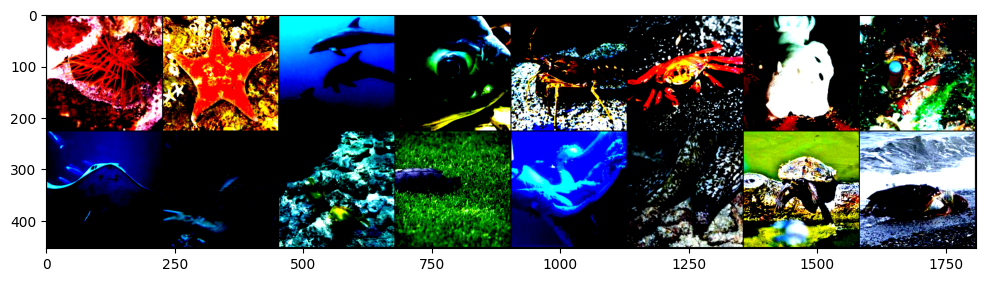

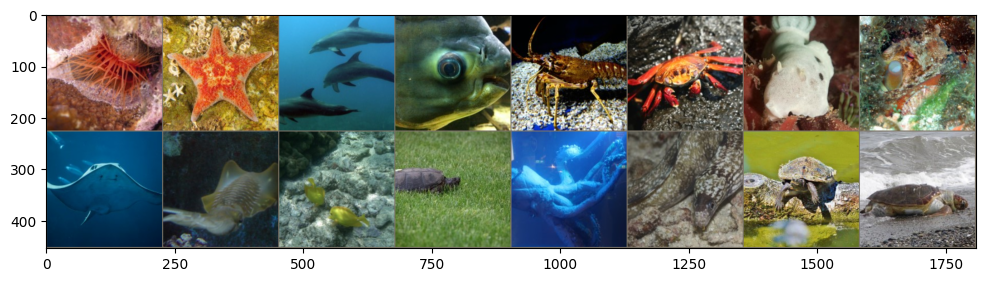

In [13]:
for images, labels in datamodule.val_dataloader():
    break
im=make_grid(images,nrow=8)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [14]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.val_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                 precision    recall  f1-score   support

          Clams     0.7456    0.6693    0.7054       127
         Corals     0.8108    0.6122    0.6977        98
          Crabs     0.6339    0.5772    0.6043       123
        Dolphin     0.7734    0.7136    0.7423       220
            Eel     0.7436    0.5225    0.6138       111
           Fish     0.6667    0.6333    0.6496       120
     Jelly Fish     0.8478    0.7573    0.8000       206
        Lobster     0.5625    0.6231    0.5912       130
    Nudibranchs     0.7129    0.6207    0.6636       116
        Octopus     0.7949    0.6370    0.7072       146
          Otter     0.6619    0.8214    0.7331       112
        Penguin     0.6475    0.7031    0.6742       128
        Puffers     0.3631    0.6019    0.4530       108
       Sea Rays     0.7736    0.6406    0.7009       128
    Sea Urchins     0.7124    0.8074    0.7569       135
       Seahorse     0.8605    0.6727    0.7551       110
           Seal     0.7835    